In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('air_pollution.csv', index_col =['date'], 
                       parse_dates =['date'] ) 
df.head()

,pollution_today,Daily Dates
date,,
2010-01-02,145.958333,2/1/2010
2010-01-03,78.833333,3/1/2010
2010-01-04,31.333333,4/1/2010
2010-01-05,42.458333,5/1/2010
2010-01-06,56.416667,6/1/2010


In [6]:
df_new=pd.DataFrame(df['pollution_today'])

#### New Dataframe created with index column (as Date) and  pollution_today from df dataframe.

In [9]:
df_new.count()

pollution_today    1000
dtype: int64

#### No Null values present

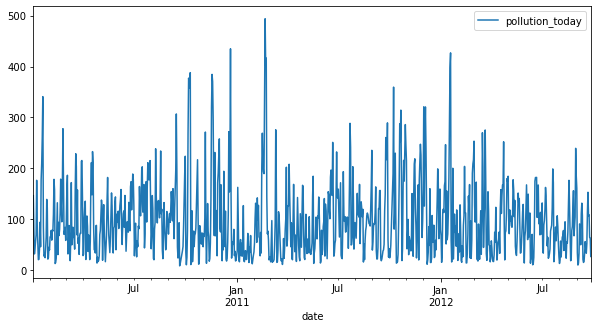

In [10]:
df_new.plot(figsize=(10,5))

#### Seasonality and almost no trend can be observed from the plot. However, the ACF & PACF plots plotted later, will give an exact idea about the trend. 

## Decomposition of plot done with Multiplicative model

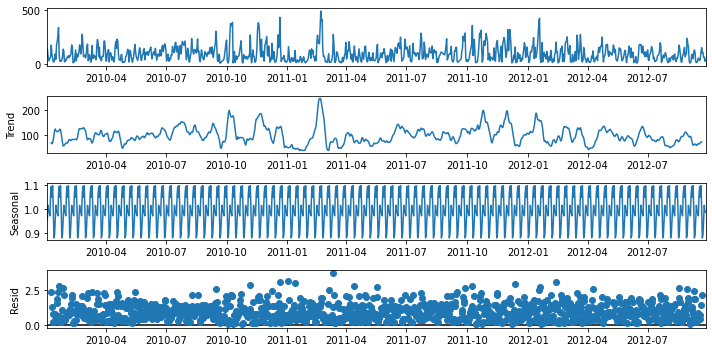

<Figure size 2880x720 with 0 Axes>

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from matplotlib import pyplot

decompose = seasonal_decompose(df_new, model='multiplicative', freq=12)
rcParams['figure.figsize'] = 10, 5
decompose.plot()
pyplot.figure(figsize=(40,10))
pyplot.show()

#### Original Time Series Plotted

In [13]:
df_new.shape

(1000, 1)

In [21]:
df_new.tail(271)

,pollution_today
date,
2012-01-01,78.958333
2012-01-02,67.583333
2012-01-03,14.791667
2012-01-04,30.666667
2012-01-05,113.083333
...,...
2012-09-23,108.250000
2012-09-24,63.625000
2012-09-25,63.000000


## Time series divided into two parts- Train & Test.

In [33]:

# Split data into train / test sets 
train = df_new.iloc[:len(df)-271] 
test = df_new.iloc[len(df)-271:] # set one year(12 months) for testing 

In [34]:
train.shape

(729, 1)

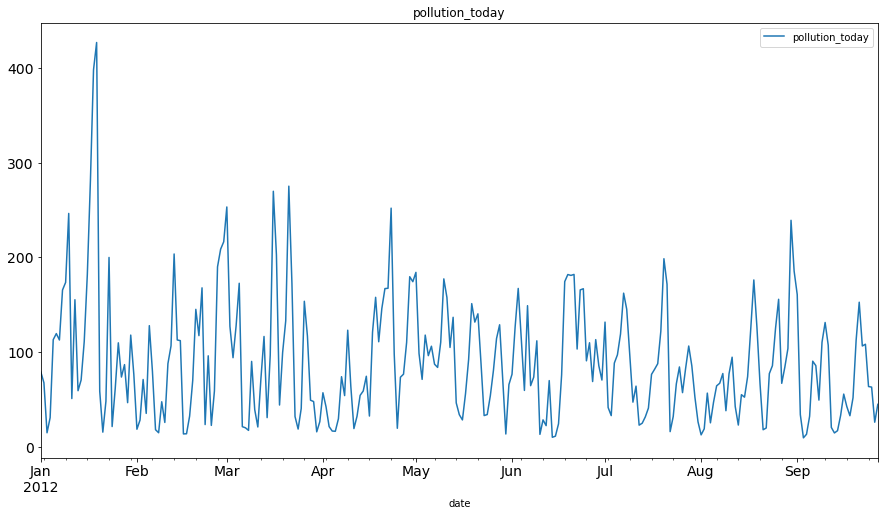

In [35]:
test.plot(figsize=(15,8), title= 'pollution_today', fontsize=14)

# Forecasting models, one by one:

## Naive Method of Forecasting

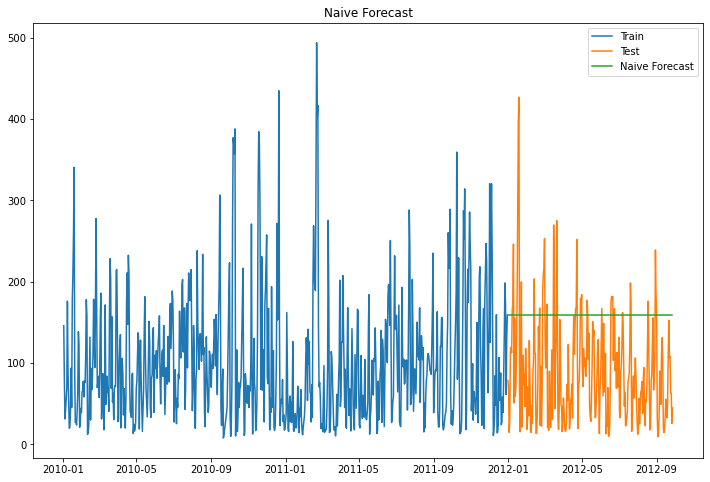

In [36]:
dd= np.asarray(train['pollution_today'])
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(12,8))
plt.plot(train.index, train['pollution_today'], label='Train')
plt.plot(test.index,test['pollution_today'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

#### Naive method forecast assumes that the next period forecast is the very last datapoint, and it continues like that.

In [118]:
from sklearn import metrics
from math import sqrt
rmse=sqrt(metrics.mean_squared_error(test['pollution_today'],y_hat['naive']))
print('RMSE for Naive Method is: ', rmse)

RMSE for Naive Method is:  94.4883955366457


#### Observations:
    * Converting the data into Numpy array, so that the original test data do not get impacted.
    * y-hat: Creating a copy of the test data.
    * Column called naive is created in y-hat, with dd array's last value.
    * The green line above is the Naive Forecast.
    * RMSE value of the actuals vs forecast is being evaluated, and printed.
    * RMSE value of 94.49 is quite large. Also, the green line above is not quite close to the orange curve. So, its not a good forecast.

In [38]:
y_hat

,pollution_today,naive
date,,
2012-01-01,78.958333,159.0
2012-01-02,67.583333,159.0
2012-01-03,14.791667,159.0
2012-01-04,30.666667,159.0
2012-01-05,113.083333,159.0
...,...,...
2012-09-23,108.250000,159.0
2012-09-24,63.625000,159.0
2012-09-25,63.000000,159.0


# Using Moving Average

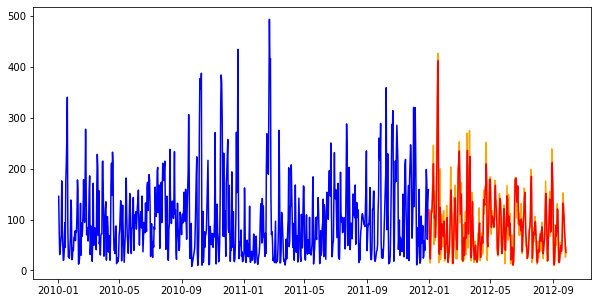

In [54]:
import pandas as pd
from matplotlib import pyplot

# Taking moving average of last 2 obs
rolling = df_new.rolling(window=2)
rolling_mean = rolling.mean()

# plot the two series
pyplot.plot(train, color='blue')
pyplot.plot(test, color='orange')
pyplot.plot(rolling_mean[len(train):], color='red')
pyplot.show()

In [55]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
from math import sqrt

print("RMSE:", sqrt(mean_squared_error(df_new[1:], rolling_mean.dropna())))

RMSE: 33.23350138765237


#### Observations:
    * 2 period Moving averages are being taken using train.rolling() method. It provides rolling window calculations.
    * RMSE value has improved to 33.234, as compared to the previous forecasting methods.
    * So far, the Moving Average has performed better than the previous methods.

# Exponential Smoothing Method

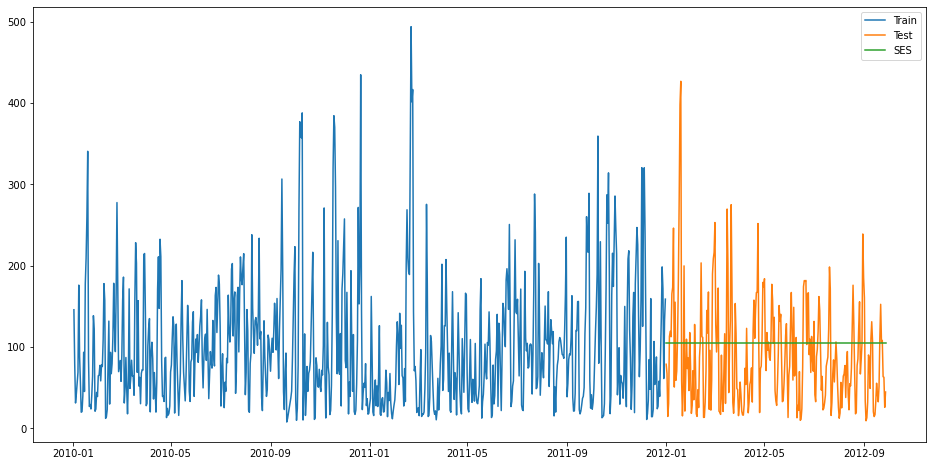

In [76]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['pollution_today'])).fit(smoothing_level=0.085,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test)) # Simple Exponential Smoothing.
plt.figure(figsize=(16,8))
plt.plot(train['pollution_today'], label='Train')
plt.plot(test['pollution_today'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

#### Simple Exponential smoothing assumes that there is no trend/no seasonality. Without these assumptions, it will try to fit into the data, and do the forecast.

In [77]:
from sklearn import metrics
from math import sqrt
rmse=sqrt(metrics.mean_squared_error(y_hat['pollution_today'],y_hat_avg['SES']))
print('RMSE for SES is: ', rmse)

RMSE for SES is:  66.16634046130957


#### Observations:
    * We can play with the smoothing level constant (alpha) to decrease the RMSE, and hence improve the model.
    * No trend or seasonality in data assumed in Exponential Smoothing.
    * Notice that the green forecast line is a straight line with zero slope, which means that there is no trend relationship in this forecast.

# Holt's Exponential Smoothing

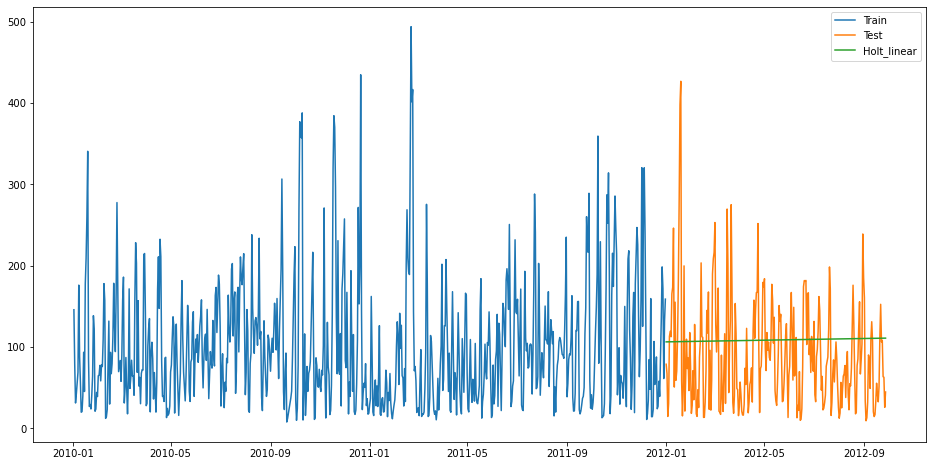

In [100]:
y_hat_avg = test.copy()

fit1 = Holt(np.asarray(train['pollution_today'])).fit(smoothing_level = 0.0001,smoothing_slope = 0.0001)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot(train['pollution_today'], label='Train')
plt.plot(test['pollution_today'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [101]:
from sklearn import metrics
from math import sqrt
rmse=sqrt(metrics.mean_squared_error(y_hat['pollution_today'],y_hat_avg['Holt_linear']))
print('RMSE for Holt_Linear_Expo_Smoothing is: ', rmse)

RMSE for Holt_Linear_Expo_Smoothing is:  67.42844174715493


#### Observations:
    * Trend is assumed.
    * In Holt's, a tilted/slanting green line can be observed. This is the biggest difference between SES and Holt's.
      Holt assumes trend.
    * We can play with the smoothing level constant (alpha) and smoothing (slope) to decrease the RMSE, and hence improve the model.
    * RMSE value reduced to 67.43 

# Holt's Winters Method

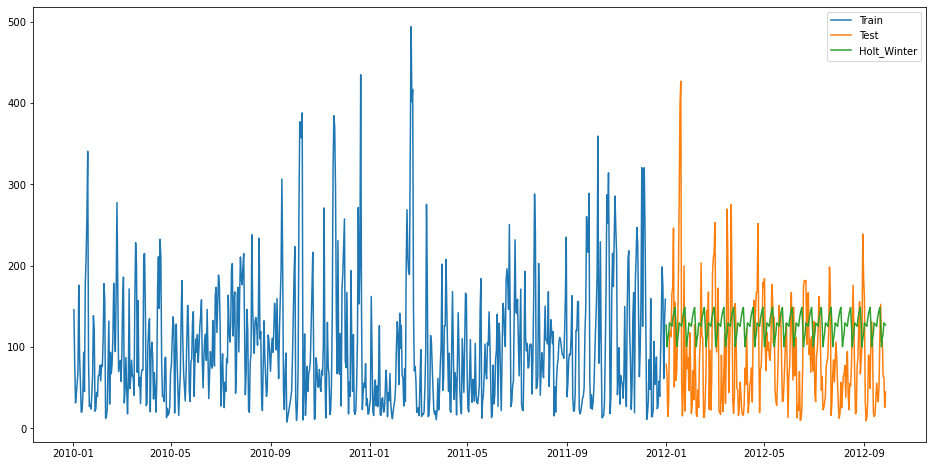

In [116]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['pollution_today']) ,seasonal_periods=12 ,trend='add', seasonal='add',).fit(use_boxcox=True)
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train['pollution_today'], label='Train')
plt.plot(test['pollution_today'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [117]:
from sklearn import metrics
from math import sqrt
rmse=sqrt(metrics.mean_squared_error(y_hat['pollution_today'],y_hat_avg['Holt_Winter']))
print('RMSE for Holt Winters Smoothing is: ', rmse)

RMSE for Holt Winters Smoothing is:  76.49918211576082


## ARIMA, AUTO-ARIMA, SARIMA model implementations:

### STATIONARY TEST

In [12]:
# Augmented Dickey Fuller Test
from statsmodels.tsa.stattools import adfuller
# from numpy import log
result=adfuller(df_new.dropna())
#result
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -16.601976
p-value: 0.000000


#### With p-value<0.05, the null gets rejected,so, it is a stationary series.

### Lets go for ACF and PACF plot for this data.

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

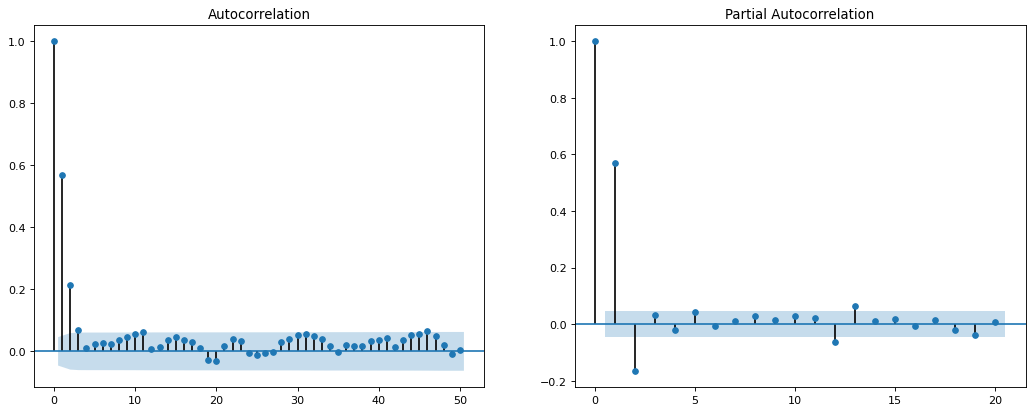

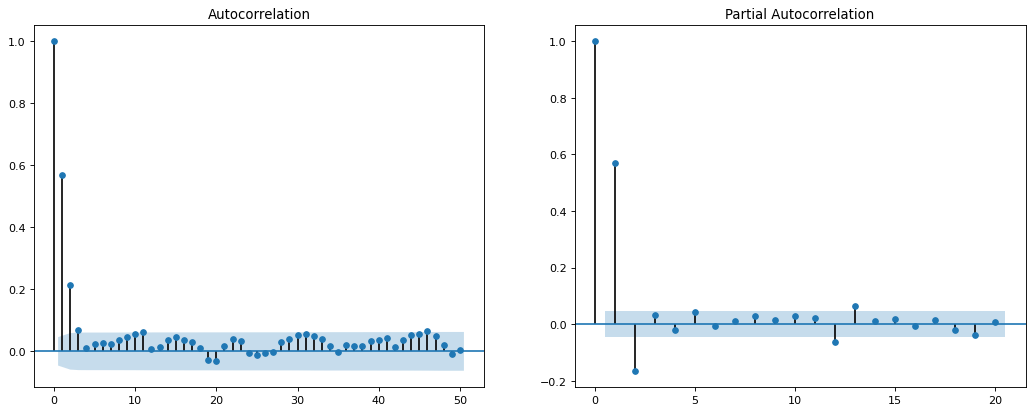

In [18]:
# Plotting ACF and PACF

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6), dpi= 80)
plot_acf(df_new, ax=ax1, lags=50)
plot_pacf(df_new, ax=ax2, lags=20)

### OBSERVATIONS:
    * We can't gather much about the trend of the plot looking at the initial plot.
    * But looking at the ACF plots, we notice that there is certainly some trend present in the data.
    * Also, there is a strong seasonality here as well.

In [19]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

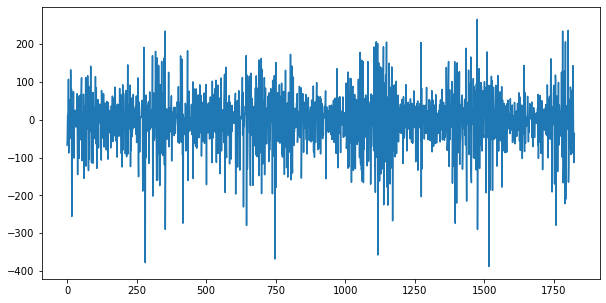

In [20]:
# difference the dataset
diff1 = difference(df_new, interval=1)
plt.plot(diff1)

There are some negative lags. But no trend here.

### Lets plot the ACF and PACF of the differenced one.

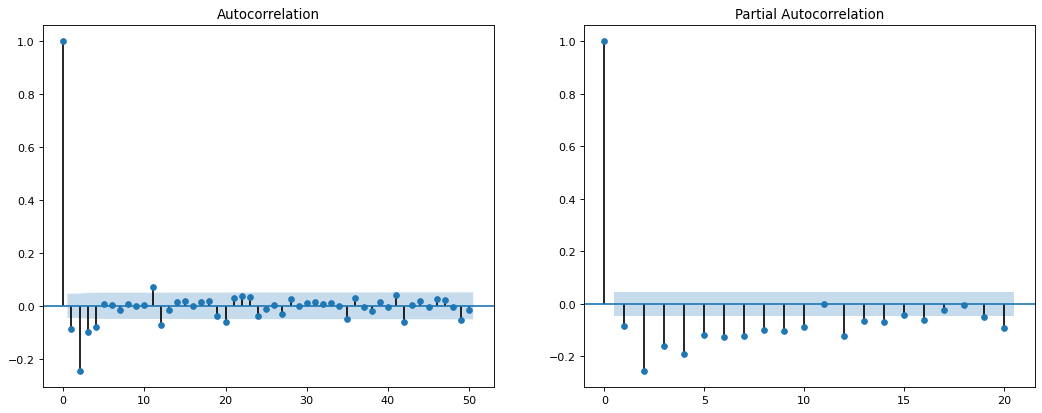

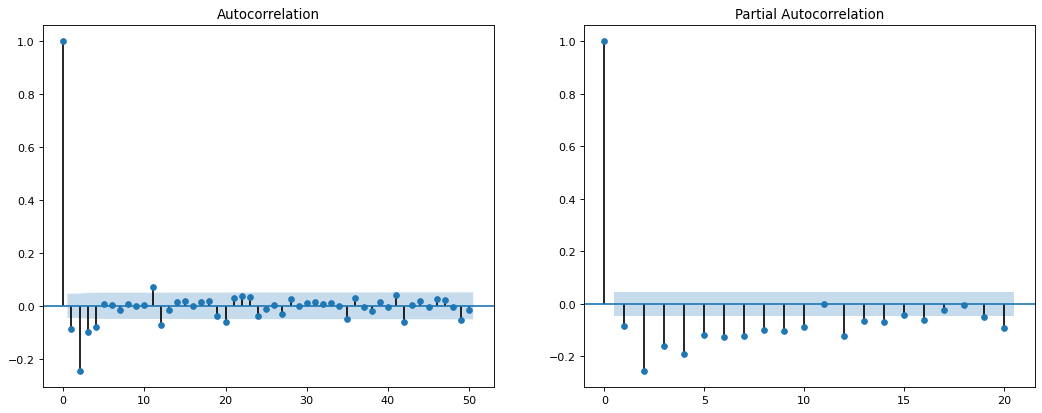

In [21]:
# Plotting ACF and PACF

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6), dpi= 80)
plot_acf(diff1, ax=ax1, lags=50)
plot_pacf(diff1, ax=ax2, lags=20)

## Observations:
    * There is one significant lag in PACF, and multiple significant lags in PACF negative lags. This depicts seasonal component in the data.
    * On top of diff1, we go for the seasonal differencing to remove the seasonal effect.Not the normal  differencing.

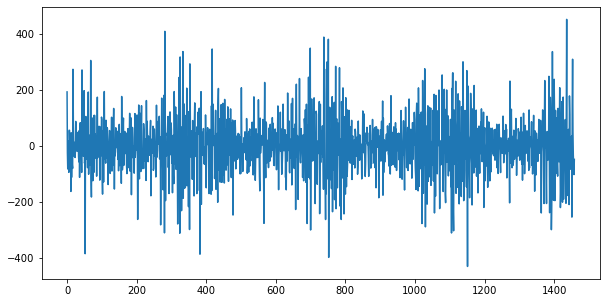

In [22]:
# difference the dataset
diff2 = difference(diff1, interval=365)
plt.plot(diff2)

# Since, its the daily data, lets take the interval as 365.

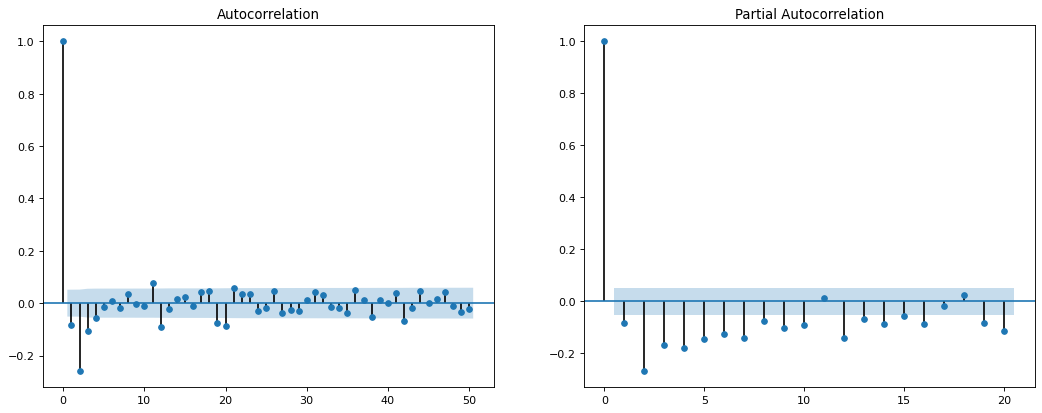

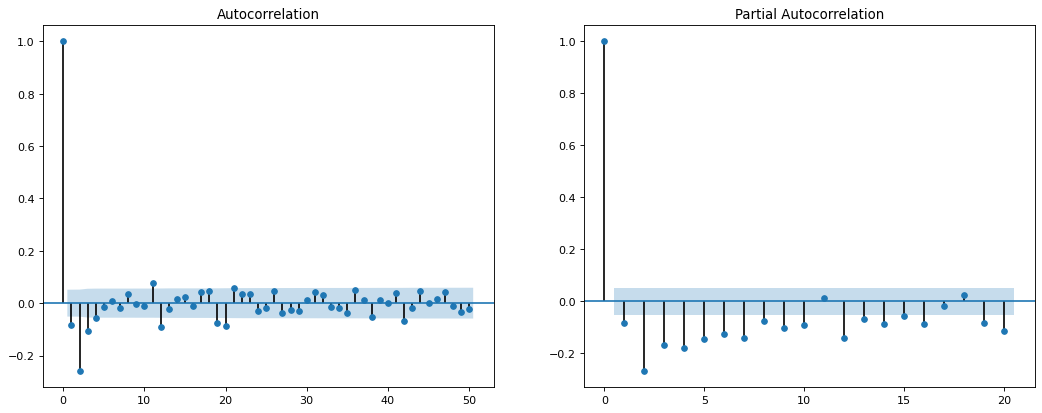

In [23]:
# Plotting ACF and PACF

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6), dpi= 80)
plot_acf(diff2, ax=ax1, lags=50)
plot_pacf(diff2, ax=ax2, lags=20)

We see multiple significant lags in PACF. So, lets go for 2nd order seasonal differencing.

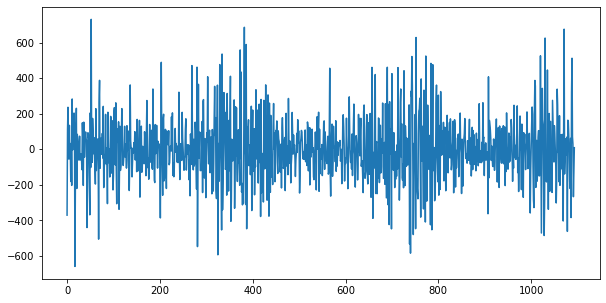

In [24]:
# difference the dataset
diff3 = difference(diff2, interval=365)
plt.plot(diff3)

# Since, its the daily data, lets take the interval as 365.

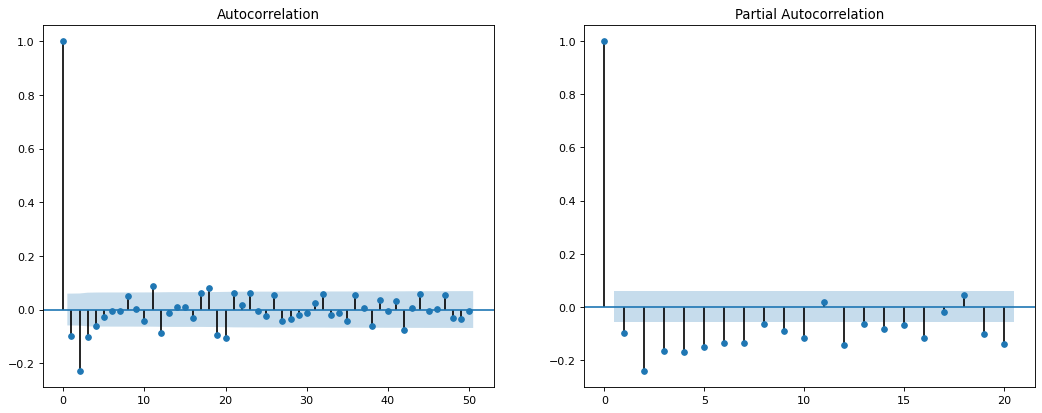

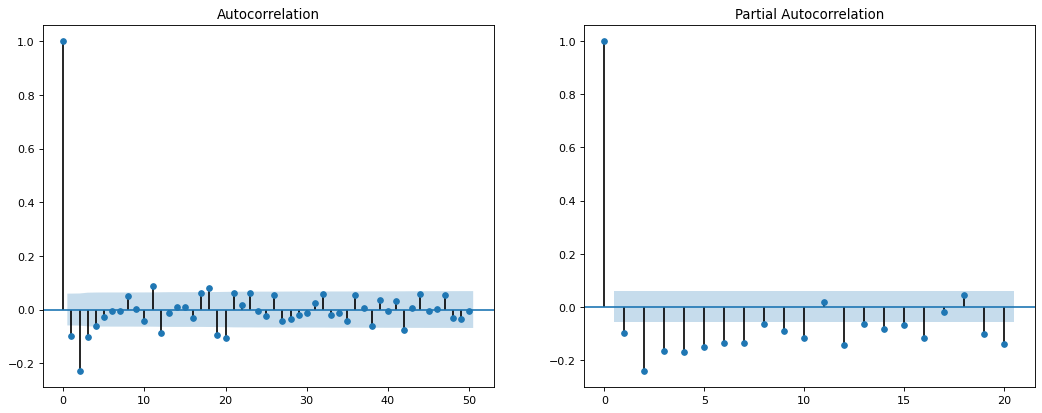

In [25]:
# Plotting ACF and PACF

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6), dpi= 80)
plot_acf(diff3, ax=ax1, lags=50)
plot_pacf(diff3, ax=ax2, lags=20)

Lets stop for some time.

In [33]:
df_new

date
2010-01-02    145.958333
2010-01-03     78.833333
2010-01-04     31.333333
2010-01-05     42.458333
2010-01-06     56.416667
                 ...    
2014-12-27    238.666667
2014-12-28    197.375000
2014-12-29    159.000000
2014-12-30     46.083333
2014-12-31     10.041667
Name: pollution_today, Length: 1825, dtype: float64

# Holt-Winters Exponential Method

In [26]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

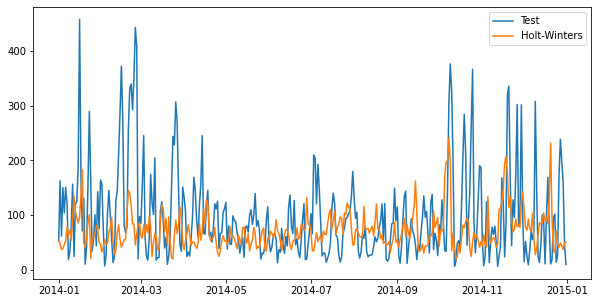

In [66]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

train, test = df_new[:1460], df_new[1460:]
model = ExponentialSmoothing(train, seasonal='mul', seasonal_periods=365).fit()
pred = model.predict(start=test.index[0], end=test.index[-1])

# plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.legend(loc='best')

## Observations:

    * Its able to capture the trend and seasonality in the data.
    * But it fails to capture offsets, irregularities in the data.

In [65]:
train.shape

(1460,)

In [56]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
from math import sqrt

print("Mean Absolute Error:", mean_absolute_error(test,pred))
print("Mean Squared Error:", mean_squared_error(test,pred))
print("RMSE:", sqrt(mean_squared_error(test,pred)))

Mean Absolute Error: 62.2162798842237
Mean Squared Error: 7968.678881093468
RMSE: 89.26745701034318


## Moving Average Method

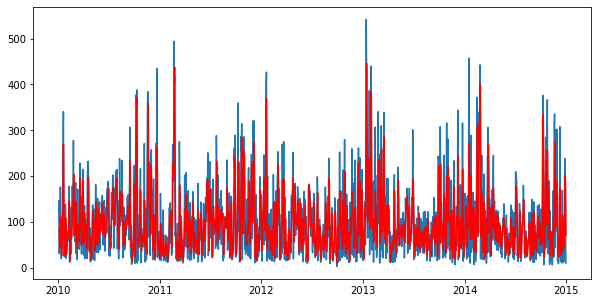

In [59]:
import pandas as pd
from matplotlib import pyplot

# Taking moving average of last 3 obs
rolling = df_new.rolling(window=3)
rolling_mean = rolling.mean()

# plot the two series
pyplot.plot(df_new)
pyplot.plot(rolling_mean, color='red')
pyplot.show()

In [60]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
from math import sqrt

print("RMSE:", sqrt(mean_squared_error(df_new[2:], rolling_mean.dropna())))

RMSE: 51.27316012253012


In [46]:
rolling_mean.dropna()

date
2010-01-04     85.375000
2010-01-05     50.875000
2010-01-06     43.402778
2010-01-07     55.958333
2010-01-08    100.541667
                 ...    
2014-12-27    145.305556
2014-12-28    202.097222
2014-12-29    198.347222
2014-12-30    134.152778
2014-12-31     71.708333
Name: pollution_today, Length: 1823, dtype: float64

In [48]:
df_new[2:]

date
2010-01-04     31.333333
2010-01-05     42.458333
2010-01-06     56.416667
2010-01-07     69.000000
2010-01-08    176.208333
                 ...    
2014-12-27    238.666667
2014-12-28    197.375000
2014-12-29    159.000000
2014-12-30     46.083333
2014-12-31     10.041667
Name: pollution_today, Length: 1823, dtype: float64

## AUTO-ARIMA

In [66]:
import pmdarima
from pmdarima import auto_arima

In [67]:
train, test = df_new[:1460], df_new[1460:]

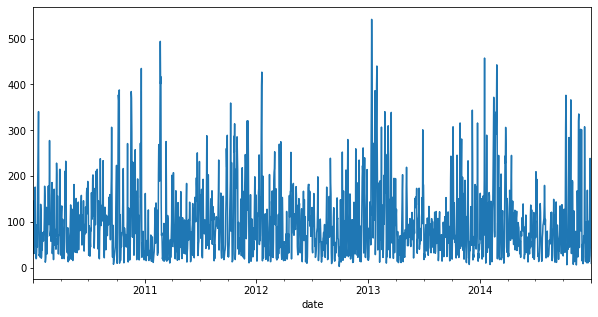

In [18]:
df_new.plot()

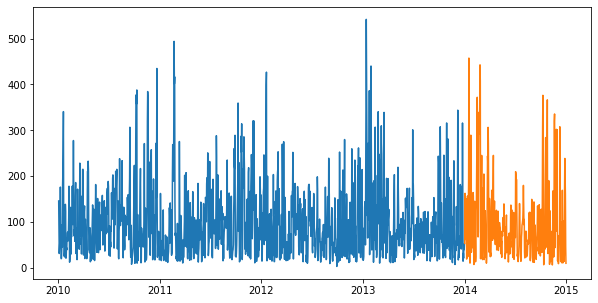

In [68]:
plt.plot(train)
plt.plot(test)

In [21]:
train.shape

(1460,)

In [55]:
train

date
2010-01-02    145.958333
2010-01-03     78.833333
2010-01-04     31.333333
2010-01-05     42.458333
2010-01-06     56.416667
                 ...    
2013-12-27     31.916667
2013-12-28     21.125000
2013-12-29     50.520833
2013-12-30     39.833333
2013-12-31     51.833333
Name: pollution_today, Length: 1460, dtype: float64

## Step6: Building Auto ARIMA model

In [102]:
arima_model=auto_arima(train, seasonal=False, 
                          error_action='ignore',trace = True,
                          supress_warnings=True)


# arima_model =  auto_arima(train,start_p=0, d=1, start_q=0, 
#                           max_p=5, max_d=5, max_q=5, start_P=0, 
#                           D=1, start_Q=0, max_P=5, max_D=5,
#                           max_Q=5, m=12, seasonal=True, 
#                           error_action='warn',trace = True,
#                           supress_warnings=True,stepwise = True,
#                           random_state=20,n_fits = 50 )

arima_model.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.84 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=18221.060, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=16450.979, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=17181.118, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=16452.345, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=16451.801, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=16445.088, Time=0.63 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=1.94 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=16256.243, Time=0.78 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=16858.722, Time=0.31 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=16207.109, Time=1.37 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=16700.792, Time=0.39 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=2.67 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=1.92 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=1

ARIMA(order=(0, 0, 3), scoring_args={}, suppress_warnings=True)

In [103]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1460
Model:               SARIMAX(0, 0, 3)   Log Likelihood               -8087.717
Date:                Sat, 19 Jun 2021   AIC                          16185.434
Time:                        17:41:28   BIC                          16211.865
Sample:                             0   HQIC                         16195.294
                               - 1460                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     98.3354      4.012     24.512      0.000      90.473     106.198
ma.L1          0.6545      0.021     31.363      0.000       0.614       0.695
ma.L2          0.2523      0.024     10.384      0.000       0.205       0.300
ma.L3          0.0945      0.022      4.245      0.000       0.051       0.138
sigma2      3792.9259    107.947     35.137      0.000    3581.353    4004.499
===================================================================================
Ljung-Box (Q):                       47.07   Jarque-Bera (JB):               307.09
Prob(Q):                              0.21   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                             0.64
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Step7: Forecasting on the test data

In [104]:
arima_model.order

(0, 0, 3)

In [108]:
# pred = pd.DataFrame(arima_model.predict(start=df_new.index[0], end=df_new.index[-1]))

# pred
from statsmodels.tsa.arima_model import ARIMA

from tqdm import tqdm
order=arima_model.order
yhat=list()
for t in tqdm(range(len(test.pollution_today))):
    temp_train=df_new[:len(train)+t]
    model=ARIMA(temp_train.pollution_today, order=order)
    model_fit=model.fit(disp=False)
    predictions=model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat=yhat+[predictions]
    
yhat=pd.concat(yhat)
# resultsDict['AutoARIMA {0}'.format(order)]=evaluate(test.pollution_today, yhat)

# predictionsDict['AutoARIMA {0}'.format(order)]=yhat.values

100%|██████████| 365/365 [01:16<00:00,  4.80it/s]


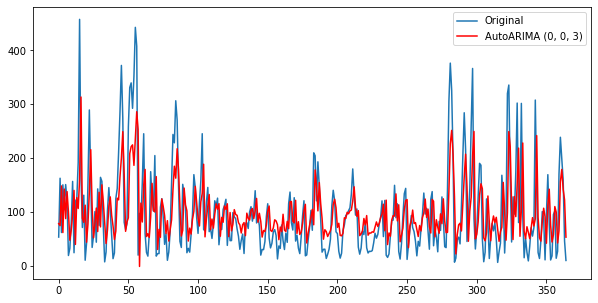

In [110]:
plt.plot(test.pollution_today.values,label='Original')
plt.plot(yhat.values, color='red', label='AutoARIMA {0}'.format(order))
plt.legend()

In [111]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

print("Mean Absolute Error:", mean_absolute_error(test,yhat))
print("RMSE:",np.sqrt(mean_squared_error(test,yhat)))

Mean Absolute Error: 46.95030030820336
RMSE: 64.6368451684614


In [ ]:
arima_model.predict(n_periods = 20)

# AIC=2k+nln(SSE/n)

More about AIC:
https://towardsdatascience.com/introduction-to-aic-akaike-information-criterion-9c9ba1c96ced

#### The lesser the AIC, better the model. AIC is a metric to compare the multiple models. 

In [30]:
import itertools

In [38]:
p=range(0,8)
q=range(0,2)
d=range(0,8)

In [39]:
pdq_combination=list(itertools.product(p,d,q))

In [40]:
pdq_combination

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (0, 2, 0),
 (0, 2, 1),
 (0, 3, 0),
 (0, 3, 1),
 (0, 4, 0),
 (0, 4, 1),
 (0, 5, 0),
 (0, 5, 1),
 (0, 6, 0),
 (0, 6, 1),
 (0, 7, 0),
 (0, 7, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1),
 (1, 2, 0),
 (1, 2, 1),
 (1, 3, 0),
 (1, 3, 1),
 (1, 4, 0),
 (1, 4, 1),
 (1, 5, 0),
 (1, 5, 1),
 (1, 6, 0),
 (1, 6, 1),
 (1, 7, 0),
 (1, 7, 1),
 (2, 0, 0),
 (2, 0, 1),
 (2, 1, 0),
 (2, 1, 1),
 (2, 2, 0),
 (2, 2, 1),
 (2, 3, 0),
 (2, 3, 1),
 (2, 4, 0),
 (2, 4, 1),
 (2, 5, 0),
 (2, 5, 1),
 (2, 6, 0),
 (2, 6, 1),
 (2, 7, 0),
 (2, 7, 1),
 (3, 0, 0),
 (3, 0, 1),
 (3, 1, 0),
 (3, 1, 1),
 (3, 2, 0),
 (3, 2, 1),
 (3, 3, 0),
 (3, 3, 1),
 (3, 4, 0),
 (3, 4, 1),
 (3, 5, 0),
 (3, 5, 1),
 (3, 6, 0),
 (3, 6, 1),
 (3, 7, 0),
 (3, 7, 1),
 (4, 0, 0),
 (4, 0, 1),
 (4, 1, 0),
 (4, 1, 1),
 (4, 2, 0),
 (4, 2, 1),
 (4, 3, 0),
 (4, 3, 1),
 (4, 4, 0),
 (4, 4, 1),
 (4, 5, 0),
 (4, 5, 1),
 (4, 6, 0),
 (4, 6, 1),
 (4, 7, 0),
 (4, 7, 1),
 (5, 0, 0),
 (5, 0, 1),
 (5, 1, 0),
 (5,

In [41]:
len(pdq_combination)

128

In [42]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

train, test = df_new[:1460], df_new[1460:]

rmse=[]
order1=[]

In [43]:
for pdq in pdq_combination:
    try:
        model=ARIMA(train, order=pdq).fit()
        pred=model.predict(start=len(train), end=(len(df_new)-1))
        error=np.sqrt(mean_squared_error(test,pred))
        order1.append(pdq)
        rmse.append(error)    
    except:
        continue

In [44]:
rmse

[81.36703681287632,
 81.35332913050668,
 127.38691893610208,
 127.38185441116504,
 127.29554657370758,
 127.35272265670118,
 81.376655789597,
 81.3603828403293,
 127.3853137112509,
 127.25425954171952,
 127.30030718461677,
 81.3560522041641,
 81.36047963763963,
 127.3814403207911,
 127.25991139404194,
 127.33549429762074,
 81.35964162549132,
 81.35097256205539,
 127.3765308611003,
 127.25907353691915,
 127.31176883609658,
 81.35414617946483,
 81.35296016344093,
 127.38729159206405,
 127.26168815427427,
 127.35230403835942,
 81.35832242825667,
 81.35488669651899,
 127.38010266439753,
 127.26238322581112,
 127.32610724644344,
 81.35789560877812,
 81.35741079933916,
 127.40415751648358,
 127.26250730562475,
 127.4350911603938,
 127.42054897034048,
 81.36107114178955,
 81.35603920381239,
 127.38289259776572,
 127.27110374826144,
 127.44406182714806,
 127.4252520664593]

In [45]:
results=pd.DataFrame(index=order1, data=rmse, columns=['RMSE'])

In [46]:
results.to_csv('TSA_Practice ARIMA_result.csv')

(3, 0, 1)	81.35097256
is the minimum RMSE value attained.

#### Lets model using ARIMA model

In [47]:
model=ARIMA(train, order=(3,0,0)).fit()

#### Predicting test dataset

In [57]:
pred=model.predict(start=test.index[0], end=test.index[-1])

In [50]:
pred.head()

2014-01-01    76.426093
2014-01-02    90.226483
2014-01-03    95.462136
2014-01-04    97.230282
2014-01-05    97.876273
Freq: D, dtype: float64

In [58]:
print('RMSE:', np.sqrt(mean_squared_error(test,pred)))

RMSE: 81.35872390063182


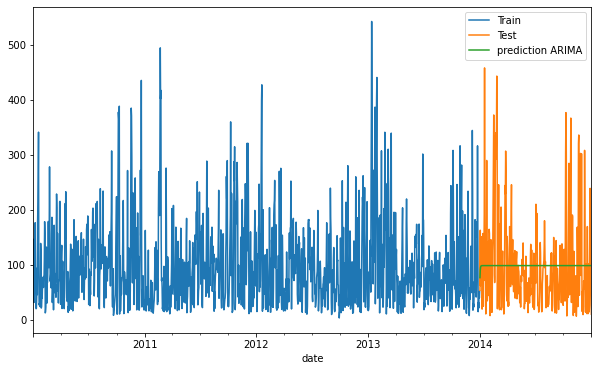

In [54]:
train.plot(legend=True, label='Train', figsize=(10,6))
test.plot(legend=True,label='Test')
pred.plot(legend=True,label='prediction ARIMA')

In [ ]:
ts=df_new['pollution_today'].resample('MS').sum()

In [ ]:
ts

In [ ]:
import matplotlib.pyplot as plt
ts.plot(figsize=(10,5))
plt.show() 

#### This seems to be a seasonal model, with almost no trend.

## STEP 4: Stationarity Check

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

decompose = seasonal_decompose(ts, model='multiplicative', freq=12)
rcParams['figure.figsize'] = 10, 5
decompose.plot()
pyplot.figure(figsize=(40,10))
pyplot.show()

#### This series has seasonality, so its a non-stationary series.
#### Series has to be made stationary, only then the forecasting can be done.

In [ ]:
# Augmented Dickey Fuller Test
from statsmodels.tsa.stattools import adfuller
# from numpy import log
result=adfuller(ts.dropna())
#result
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

#### With p-value<0.05, the null gets rejected,so, it is a stationary series.

In [ ]:
from pmdarima.arima.utils import ndiffs

ndiffs(ts, test='adf')

#### No differencing is required here.

In [ ]:
len(ts)

In [ ]:
train=ts[:49]
test=ts[49:]

In [ ]:
print(test,train)

#### Data split into Train and Test. Our plan is to first create a model based on Train. Then test it on the test data. After tuning the model, post obtaininf RMSE etc, we again retrain the entire model on the entire train+test, so as to finally do forecasting for the future.
#### SARIMA (Seasonal ARIMA) can be applied in the model.

### Step 2: Plot ACF and PACF to get preliminary understanding of the process

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
# Plotting ACF and PACF

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6), dpi= 80)
plot_acf(ts, ax=ax1, lags=50)
plot_pacf(ts, ax=ax2, lags=20)

#### looking at the plots, we see that series is more or less stationary, but there is 1 significant lag in Autocorrelation plot, 
#### non-seasonal MA(1). In PACF plot, there are seasonal lags. So, Seasonal ARIMA of 12 periods, with AR(6) can be applied.

#### Perform a non-seasonal differencing. ARIMA(0,0,1)(0,1,0)12

In [ ]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

In [ ]:
# difference the dataset
seriesdiff = difference(ts, interval=12)
plt.plot(seriesdiff12)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6), dpi= 80)
plot_acf(seriesdiff12, ax=ax1, lags=15)
plot_pacf(seriesdiff12, ax=ax2, lags=15)

In [ ]:
# difference the dataset
seriesdiff12 = difference(ts, interval=12)
plt.plot(seriesdiff12)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6), dpi= 80)
plot_acf(seriesdiff12, ax=ax1, lags=20)
plot_pacf(seriesdiff12, ax=ax2, lags=20)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order = (0,0,1)
seasonal_order = (0,1,0,12)

# fit model
model = SARIMAX(train, order= order, seasonal_order= seasonal_order)
model_fit = model.fit()

In [ ]:
print(model_fit.summary())

In [ ]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot

In [ ]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

In [ ]:
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()

In [ ]:
len(test)

In [ ]:
pred = model_fit.forecast(11)
pred

In [ ]:
pyplot.plot(test)
pyplot.plot(pred, color='red')
pyplot.show()

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
from math import sqrt

print("Mean Absolute Error:", mean_absolute_error(test,pred))
print("Mean Squared Error:", mean_squared_error(test,pred))
print("Root Mean Squared Error:", sqrt(mean_squared_error(test,pred)))

## AUTO-ARIMA with Seasonal Component

In [120]:
import pmdarima
from pmdarima import auto_arima

In [121]:
arima_model =  auto_arima(train,start_p=0, d=1, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=8616.900, Time=1.61 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=8408.776, Time=0.80 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.42 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=8608.065, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=8292.067, Time=2.01 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=8256.537, Time=4.04 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=8240.516, Time=7.44 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=8198.766, Time=18.55 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=39.89 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=26.34 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=8201.048, Time=10.35 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=8154.887, Time=18.00 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=8190.463, Time=9.43 sec
 ARIMA(2,1,0)(5,1,1)[12]             : AIC=inf, Time=53.54 sec
 ARIMA(2,1,0)(4,1,1)[12]         

In [122]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  729
Model:             SARIMAX(5, 1, 0)x(5, 1, 0, 12)   Log Likelihood               -4048.696
Date:                            Tue, 29 Jun 2021   AIC                           8119.392
Time:                                    17:57:36   BIC                           8169.703
Sample:                                         0   HQIC                          8138.820
                                            - 729                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1588      0.033     -4.876      0.000      -0.223      -0.095
ar.L2         -0.3192      0.036     -8.885      0.000      -0.390      -0.249
ar.L3         -0.1492      0.034     -4.367      0.000      -0.216      -0.082
ar.L4         -0.2018      0.034     -5.940      0.000      -0.268      -0.135
ar.L5         -0.1257      0.038     -3.295      0.001      -0.200      -0.051
ar.S.L12      -0.8646      0.034    -25.585      0.000      -0.931      -0.798
ar.S.L24      -0.7515      0.046    -16.283      0.000      -0.842      -0.661
ar.S.L36      -0.5198      0.048    -10.846      0.000      -0.614      -0.426
ar.S.L48      -0.3688      0.045     -8.209      0.000      -0.457      -0.281
ar.S.L60      -0.2456      0.037     -6.689      0.000      -0.318      -0.174
sigma2      4676.9475    203.560     22.976      0.000    4277.978    5075.917
===================================================================================
Ljung-Box (Q):                       65.48   Jarque-Bera (JB):                60.04
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.53   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Using the trained model which was built in the earlier step to forecast the sales on the test data.

In [125]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 271),index=test.index)
prediction.columns = ['predicted_sales']
prediction

,predicted_sales
date,
2012-01-01,150.883159
2012-01-02,188.833919
2012-01-03,145.559945
2012-01-04,55.894173
2012-01-05,58.341127
...,...
2012-09-23,89.221327
2012-09-24,58.140570
2012-09-25,50.405960


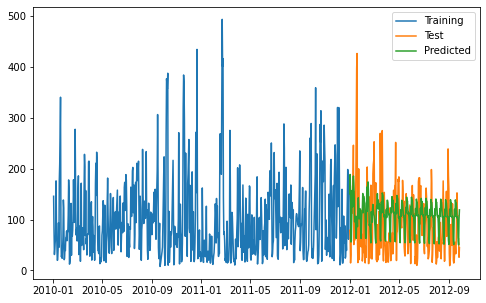

In [126]:
plt.figure(figsize=(8,5))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'Left corner')
plt.show()

In [127]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

print("Mean Absolute Error:", mean_absolute_error(test,prediction))
print("RMSE:",np.sqrt(mean_squared_error(test,prediction)))

Mean Absolute Error: 59.741191833078716
RMSE: 74.870889815645


In [128]:
arima_model.predict(n_periods = 20)

array([150.88315922, 188.83391901, 145.55994541,  55.89417286,
        58.341127  , 112.23112396, 157.48590672, 124.85988879,
       176.95741185, 185.84982573, 172.38243589, 143.80594482,
        95.79463859, 106.92250632, 101.56815733,  64.33569007,
        63.15239841, 101.32305801, 106.87703677,  86.1310222 ])